# DrawPSF for paper for AuxTel


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS

- creation date : May 18th 2020
- update : March 2021


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib as mpl
import pandas as pd
import itertools
import matplotlib.gridspec as gridspec
from matplotlib.patches import Circle,Ellipse

import matplotlib.colors as colors
import matplotlib.cm as cmx

In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (13, 13),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.size': 14}
plt.rcParams.update(params)

In [3]:
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model

In [4]:
from datetime import datetime,date

In [5]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [6]:
import matplotlib.offsetbox
from matplotlib.lines import Line2D

##### scale bar
https://stackoverflow.com/questions/43258638/is-there-a-convenient-way-to-add-a-scale-indicator-to-a-plot-in-matplotlib

In [7]:
class AnchoredHScaleBar(matplotlib.offsetbox.AnchoredOffsetbox):
    """ size: length of bar in data units
        extent : height of bar ends in axes units """
    def __init__(self, size=1, extent = 0.03, label="", loc=2, ax=None,
                 pad=0.4, borderpad=0.5, ppad = 0, sep=2, prop=None, 
                 frameon=True, linekw={},textkw={} ,**kwargs):
        if not ax:
            ax = plt.gca()
        trans = ax.get_xaxis_transform()
        size_bar = matplotlib.offsetbox.AuxTransformBox(trans)
        line = Line2D([0,size],[0,0], **linekw)
        vline1 = Line2D([0,0],[-extent/2.,extent/2.], **linekw)
        vline2 = Line2D([size,size],[-extent/2.,extent/2.], **linekw)
        size_bar.add_artist(line)
        size_bar.add_artist(vline1)
        size_bar.add_artist(vline2)
        txt = matplotlib.offsetbox.TextArea(label, minimumdescent=False,textprops=textkw)
        self.vpac = matplotlib.offsetbox.VPacker(children=[size_bar,txt],  
                                 align="center", pad=ppad, sep=sep) 
        matplotlib.offsetbox.AnchoredOffsetbox.__init__(self, loc, pad=pad, 
                 borderpad=borderpad, child=self.vpac, prop=prop, frameon=frameon,
                 **kwargs)

## Constants for conversions

In [8]:
m_to_mm=1000.
mm_to_m=1e-3
mm_to_micr=1e3
inch_to_mm=25.4
mm_to_inch=1./inch_to_mm
micr_to_m=1e-6
micr_to_mm=1e-3
m_to_micr=1./micr_to_m
m_to_cm=100.
m_to_nm=1e9
nm_to_m=1./m_to_nm

In [9]:
arcdeg_to_arcmin=60.
arcmin_to_arcdeg=1./arcdeg_to_arcmin
arcmin_to_arcsec=60.
arcdeg_to_arcsec=arcdeg_to_arcmin*arcmin_to_arcsec
arcsec_to_arcdeg=1./arcdeg_to_arcsec

In [10]:
deg_to_rad=np.pi/180.

In [11]:
rad_to_deg=1./deg_to_rad
rad_to_arcsec=rad_to_deg*arcdeg_to_arcsec
rad_to_arcmin=rad_to_deg*arcdeg_to_arcmin
arcmin_to_rad=1./rad_to_arcmin

## Configuration parameters at the telescope

#### telescope

In [12]:
Tel_Focal_Length=21.6 # m : Focal length of the telescope
Tel_Diameter=1.2 # m : Diameter of the telescope    
Tel_Fnum=Tel_Focal_Length/Tel_Diameter
pltscale=206265/(Tel_Focal_Length*m_to_mm)  # arcsec per mm

In [13]:
print("plate_scale={:2.2f} arcsec per mm ".format(pltscale))

plate_scale=9.55 arcsec per mm 


In [14]:
print("1 arsec = {:2.2f} microns".format(1/pltscale*mm_to_micr))

1 arsec = 104.72 microns


#### filter

In [15]:
Filt_D=0.265 # m distance of the filter position wrt CCD plane
Filt_size=3*inch_to_mm

#### CCD detector

In [16]:
Det_xpic=10.0 # microns per pixel
#Det_NbPix=2048 # number of pixels per CCD side
Det_NbPix=4096 # number of pixels per CCD side For 400 only
Det_size=2*Det_xpic*Det_NbPix*micr_to_mm # CCD size in mm, 5 cm or 2 inch

## Input file

In [17]:
# number of rays
NBEAM_X=11
NBEAM_Y=11
NBEAM=NBEAM_X*NBEAM_Y
NWL=4
NBTOT=NBEAM*NWL

In [18]:
theta_x=0.  # angle in arcmin
theta_y=0.  # angle in arcmin 

In [19]:
theta_x_num=int(theta_x*10)
theta_y_num=int(theta_y*10)

In [20]:
if theta_x_num>0:
    theta_nstr='{:0>2}'.format(theta_x_num)
    theta_x_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_x_num)
    theta_x_str="m"+theta_nstr

In [21]:
if theta_y_num>0:
    theta_nstr='{:0>2}'.format(theta_y_num)
    theta_y_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_y_num)
    theta_y_str="m"+theta_nstr

In [22]:
Beam4_Rayfile="Beam4_Rayfile_{:d}_allwl_{}_{}".format(NBTOT,theta_x_str,theta_y_str)

In [23]:
Beam4_Rayfile

'Beam4_Rayfile_484_allwl_m00_m00'

In [24]:
order="OP1"
order_str="+1"

# Read input files

In [25]:
rayfile_hoe="HOE_"+Beam4_Rayfile+"_RAY_OUT.xlsx"
rayfile_R150="R150_"+Beam4_Rayfile+"_RAY_OUT.xlsx"
rayfile_hoetilt="HOETILT_"+Beam4_Rayfile+"_RAY_OUT.xlsx"

In [26]:
def GetBeamParam(df):
    X0C=df["X0"].mean()
    Y0C=df["Y0"].mean()
    RXMAX=np.max(np.abs(df["X0"].values-X0C))
    RYMAX=np.max(np.abs(df["Y0"].values-Y0C))   
    RMAX=np.max(np.array([RXMAX,RYMAX]))
    return X0C,Y0C,RMAX

In [27]:
def Select_Beam(row):
    return (row["X0"]-X0C)**2+(row["Y0"]-Y0C)**2 <= RMAX**2

## Hologram

In [28]:
input_hoe = pd.ExcelFile(rayfile_hoe)
df_hoe = input_hoe.parse(index_row=0,header=1)
#df_hoe=df_hoe.iloc[0:NBTOT]
df_hoe=df_hoe.drop(0)

In [29]:
# rename columns otherwise they are not recognize and swap X,Y
df_hoe.columns = ["X0","Y0","Z0","U0","V0","W0","wave","col","X1","Y1","Z1","X2","Y2","Z2","X3","Y3","Z3","Xgoal","Ygoal","Xfinal","Yfinal","Zfinal","Notes","Unnamed"]

In [30]:
df_hoe

,X0,Y0,Z0,U0,V0,W0,wave,col,X1,Y1,...,X3,Y3,Z3,Xgoal,Ygoal,Xfinal,Yfinal,Zfinal,Notes,Unnamed
1,-7.36016,-7.36016,0,0.0277528,0.0277528,0.999229,0.0004,b,-5.55484,-5.55484,...,12.4006,-0.00625,265,0,0,12.4006,-0.00625,265,OK,3.0
2,-5.88813,-7.36016,0,0.0222053,0.0277567,0.999368,0.0004,b,-4.44387,-5.55484,...,12.4043,-0.00626,265,0,0,12.4043,-0.00626,265,OK,3.0
3,-4.4161,-7.36016,0,0.0166558,0.0277596,0.999476,0.0004,b,-3.3329,-5.55484,...,12.408,-0.00631,265,0,0,12.408,-0.00631,265,OK,3.0
4,-2.94407,-7.36016,0,0.0111047,0.0277618,0.999553,0.0004,b,-2.22194,-5.55484,...,12.4118,-0.00632,265,0,0,12.4118,-0.00632,265,OK,3.0
5,-1.47203,-7.36016,0,0.0055526,0.0277631,0.999599,0.0004,b,-1.11097,-5.55484,...,12.4155,-0.00634,265,0,0,12.4155,-0.00634,265,OK,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,1.47203,7.36016,0,-0.0055526,-0.0277631,0.999599,0.001,k,1.11097,5.55484,...,31.3556,-0.02496,265,0,0,31.3556,-0.02496,265,OK,3.0
481,2.94407,7.36016,0,-0.0111047,-0.0277618,0.999553,0.001,k,2.22194,5.55484,...,31.3406,-0.02489,265,0,0,31.3406,-0.02489,265,OK,3.0
482,4.4161,7.36016,0,-0.0166558,-0.0277596,0.999476,0.001,k,3.3329,5.55484,...,31.3257,-0.0248,265,0,0,31.3257,-0.0248,265,OK,3.0
483,5.88813,7.36016,0,-0.0222053,-0.0277567,0.999368,0.001,k,4.44387,5.55484,...,31.3108,-0.02476,265,0,0,31.3108,-0.02476,265,OK,3.0


In [31]:
X0C,Y0C,RMAX=GetBeamParam(df_hoe)

In [32]:
df_filter=df_hoe.copy()
df_filter=df_filter.loc[df_filter.apply(Select_Beam, axis=1)]
df_filter=df_filter.reset_index()   # reset index
df_hoe=df_filter.copy()

Text(0.5, 0.98, 'HOE :Filtered circular beam')

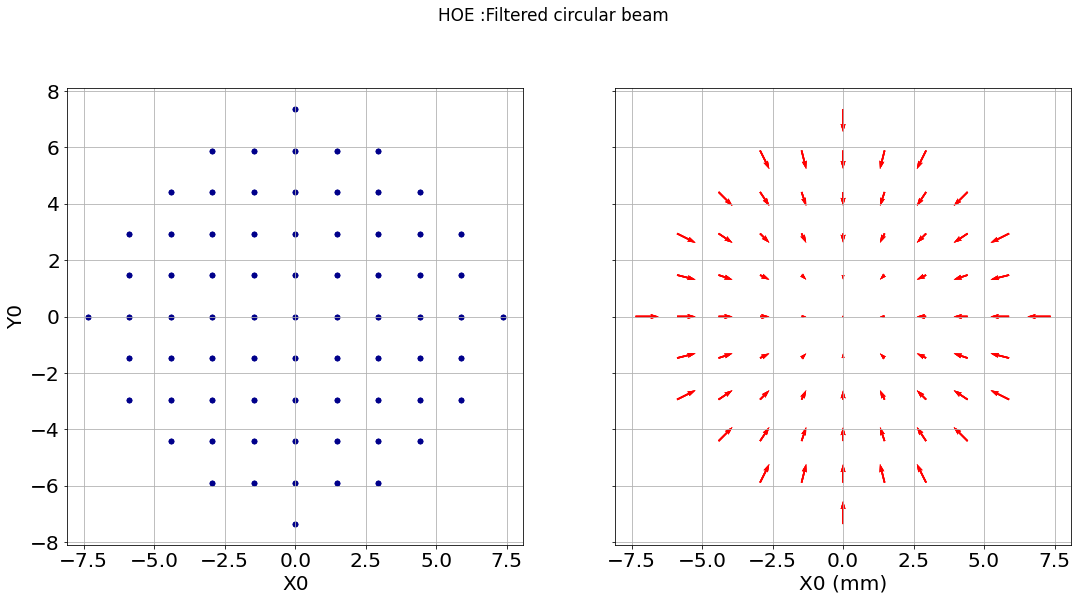

In [33]:
X0=np.array(df_filter["X0"].values,dtype='float64')
Y0=np.array(df_filter["Y0"].values,dtype='float64')
V0=np.array(df_filter["V0"].values,dtype='float64')
U0=np.array(df_filter["U0"].values,dtype='float64')

f, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,9),sharex=True,sharey=True)
df_filter.plot.scatter(x="X0", y="Y0",c="DarkBlue",marker="o",ax=ax1)
ax1.set_aspect("equal")
ax1.grid()

q = ax2.quiver(X0,Y0, U0,V0,color="red")
ax2.set_aspect("equal")
ax2.set_xlabel("X0 (mm)")
ax2.grid()

plt.suptitle("HOE :Filtered circular beam")

## HOE TILT

In [34]:
input_hoe = pd.ExcelFile(rayfile_hoetilt)
df_hoetilt = input_hoe.parse(index_row=0,header=1)
#df_hoe=df_hoe.iloc[0:NBTOT]

In [35]:
df_hoetilt=df_hoetilt.drop(0)
df_hoetilt = df_hoetilt.reset_index()

In [36]:
# rename columns
df_hoetilt.columns = ["index","X0","Y0","Z0","U0","V0","W0","wave","col","X1","Y1","Z1","X2","Y2","Z2","X3","Y3","Z3","Xgoal","Ygoal","Xfinal","Yfinal","Zfinal","Notes","Unnamed"]

In [37]:
X0C,Y0C,RMAX=GetBeamParam(df_hoetilt)

In [38]:
df_filter=df_hoetilt.copy()
df_filter=df_filter.loc[df_filter.apply(Select_Beam, axis=1)]
df_filter=df_filter.reset_index()   # reset index
df_hoetilt=df_filter.copy()

In [39]:
X0=np.array(df_filter["X0"].values,dtype='float64')
Y0=np.array(df_filter["Y0"].values,dtype='float64')
V0=np.array(df_filter["V0"].values,dtype='float64')
U0=np.array(df_filter["U0"].values,dtype='float64')

Text(0.5, 0.98, 'HOE - tilt source plane : Filtered circular beam')

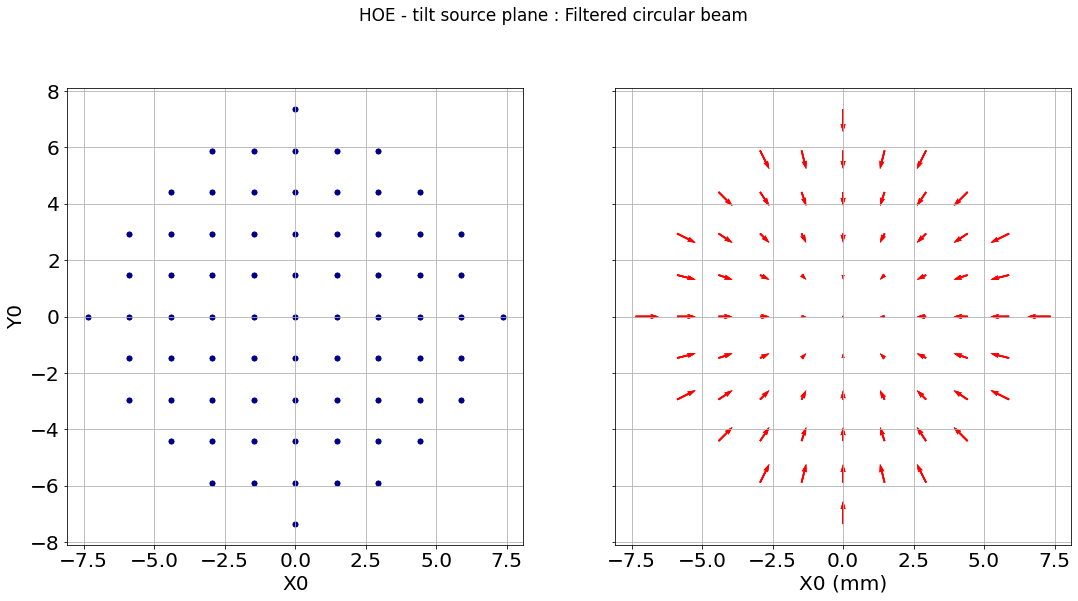

In [40]:
f, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,9),sharex=True,sharey=True)
df_filter.plot.scatter(x="X0", y="Y0",c="DarkBlue",marker="o",ax=ax1)
ax1.set_aspect("equal")
ax1.grid()

q = ax2.quiver(X0,Y0,U0,V0,color="red")
ax2.set_aspect("equal")
ax2.set_xlabel("X0 (mm)")
ax2.grid()

plt.suptitle("HOE - tilt source plane : Filtered circular beam")

# 

## Ronchi 150

In [41]:
input_R150 = pd.ExcelFile(rayfile_R150)
df_R150 = input_R150.parse(index_row=0,header=1)
#df_R150=df_R150.iloc[0:NBTOT]

In [42]:
df_R150=df_R150.drop(0)
df_R150 = df_R150.reset_index()

In [43]:
df_R150

,index,X0,Y0,Z0,U0,V0,W0,wave,col,X1,...,X3,Y3,Z3,Xgoal,Ygoal,Xfinal,Yfinal,Zfinal,Notes,Unnamed: 23
0,1,-7.36016,-7.36016,0,0.0277528,0.0277528,0.999229,0.0004,b,-5.55484,...,12.0102,0.01928,265,0,0,12.0102,0.01928,265,OK,3.0
1,2,-5.88813,-7.36016,0,0.0222053,0.0277567,0.999368,0.0004,b,-4.44387,...,11.9991,0.01743,265,0,0,11.9991,0.01743,265,OK,3.0
2,3,-4.4161,-7.36016,0,0.0166558,0.0277596,0.999476,0.0004,b,-3.3329,...,11.9892,0.01554,265,0,0,11.9892,0.01554,265,OK,3.0
3,4,-2.94407,-7.36016,0,0.0111047,0.0277618,0.999553,0.0004,b,-2.22194,...,11.9804,0.0137,265,0,0,11.9804,0.0137,265,OK,3.0
4,5,-1.47203,-7.36016,0,0.0055526,0.0277631,0.999599,0.0004,b,-1.11097,...,11.9727,0.01185,265,0,0,11.9727,0.01185,265,OK,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,480,1.47203,7.36016,0,-0.0055526,-0.0277631,0.999599,0.001,k,1.11097,...,30.1666,-0.05855,265,0,0,30.1666,-0.05855,265,OK,3.0
480,481,2.94407,7.36016,0,-0.0111047,-0.0277618,0.999553,0.001,k,2.22194,...,30.1325,-0.0538,265,0,0,30.1325,-0.0538,265,OK,3.0
481,482,4.4161,7.36016,0,-0.0166558,-0.0277596,0.999476,0.001,k,3.3329,...,30.1014,-0.04905,265,0,0,30.1014,-0.04905,265,OK,3.0
482,483,5.88813,7.36016,0,-0.0222053,-0.0277567,0.999368,0.001,k,4.44387,...,30.0731,-0.04437,265,0,0,30.0731,-0.04437,265,OK,3.0


In [44]:
X0C,Y0C,RMAX=GetBeamParam(df_R150)

In [45]:
df_filter=df_R150.copy()
df_filter=df_filter.loc[df_filter.apply(Select_Beam, axis=1)]
df_filter=df_filter.reset_index()   # reset index
df_R150=df_filter.copy()

Text(0.5, 0.98, 'R150 :Filtered circular beam')

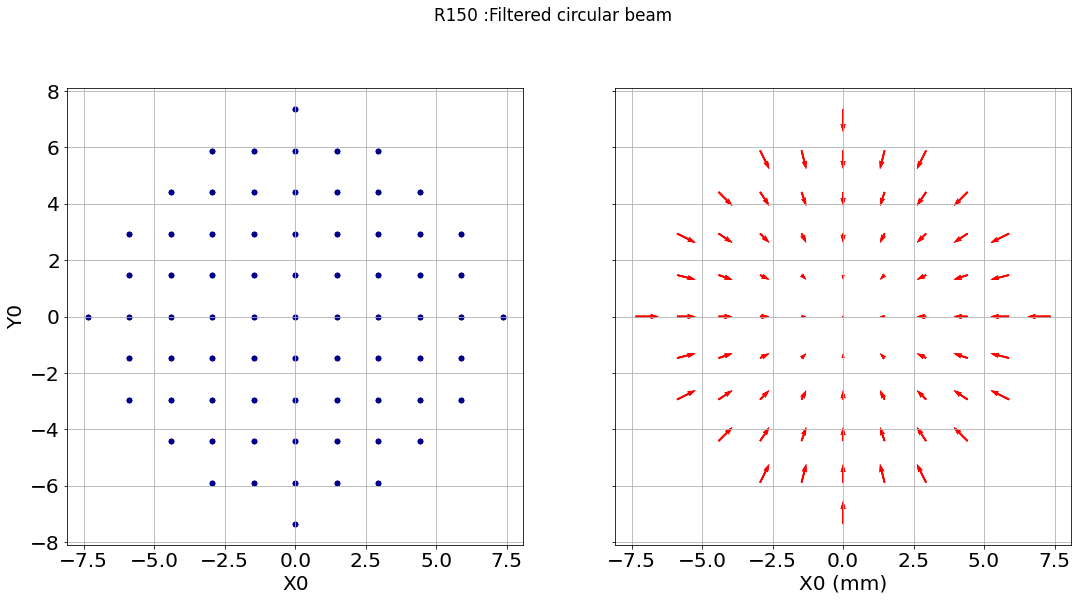

In [46]:
X0=np.array(df_filter["X0"].values,dtype='float64')
Y0=np.array(df_filter["Y0"].values,dtype='float64')
V0=np.array(df_filter["V0"].values,dtype='float64')
U0=np.array(df_filter["U0"].values,dtype='float64')

f, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,9),sharex=True,sharey=True)
df_filter.plot.scatter(x="X0", y="Y0",c="DarkBlue",marker="o",ax=ax1)
ax1.set_aspect("equal")
ax1.grid()

q = ax2.quiver(X0,Y0,U0,V0,color="red")
ax2.set_aspect("equal")
ax2.set_xlabel("X0 (mm)")
ax2.grid()

plt.suptitle("R150 :Filtered circular beam")

# Choose disperser

In [47]:
FLAG_R150 = False
FLAG_HOE = True
FLAG_HOETILT = False

In [48]:
Beam4_Rayfile

'Beam4_Rayfile_484_allwl_m00_m00'

In [49]:
if FLAG_R150:
    df=df_R150
    outputdata_excel="R150_PSF_"+ Beam4_Rayfile+"_out.xlsx"
    figname1="R150_DISP_"+  Beam4_Rayfile+".pdf"
    figname2="R150_PSF_" +   Beam4_Rayfile+".pdf"  
    figname3="R150_PSF_" +   Beam4_Rayfile+"_v2.pdf"  
    fulltitle1="Ronchi 150 : Dispersion at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)
    fulltitle2="Ronchi 150 : PSF at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)

elif FLAG_HOETILT:
    df=df_hoetilt
    outputdata_excel="HOETILT_PSF_"+ Beam4_Rayfile+"_out.xlsx"
    figname1="HOETILT_DISP_"+  Beam4_Rayfile+".pdf"
    figname2="HOETILT_PSF_" +   Beam4_Rayfile+".pdf" 
    figname3="HOETILT_PSF_" +   Beam4_Rayfile+"_v2.pdf"  
    fulltitle1="HOETILT : Dispersion at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)
    fulltitle="HOETILT : PSF at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)
else:
    df=df_hoe
    outputdata_excel="HOE_PSF_"+ Beam4_Rayfile+"_out.xlsx"
    figname1="HOE_DISP_"+  Beam4_Rayfile+".pdf"
    figname2="HOE_PSF_" +   Beam4_Rayfile+".pdf" 
    figname3="HOE_PSF_" +   Beam4_Rayfile+"_v2.pdf"  
    fulltitle1="HOE : Dispersion at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)
    fulltitle="HOE : PSF at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)

# Where the beam are going

In [50]:
WL_IR=0.001

In [51]:
df_IR=df.loc[df.wave==WL_IR]

In [52]:
NBEAMS=len(df_IR)

In [53]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBEAMS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBEAMS), alpha=1)

<ipython-input-54-3f70132aae35>:17: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.suptitle("wavelength = 1 $\mu$ m",Y=1.1,fontsize=25)


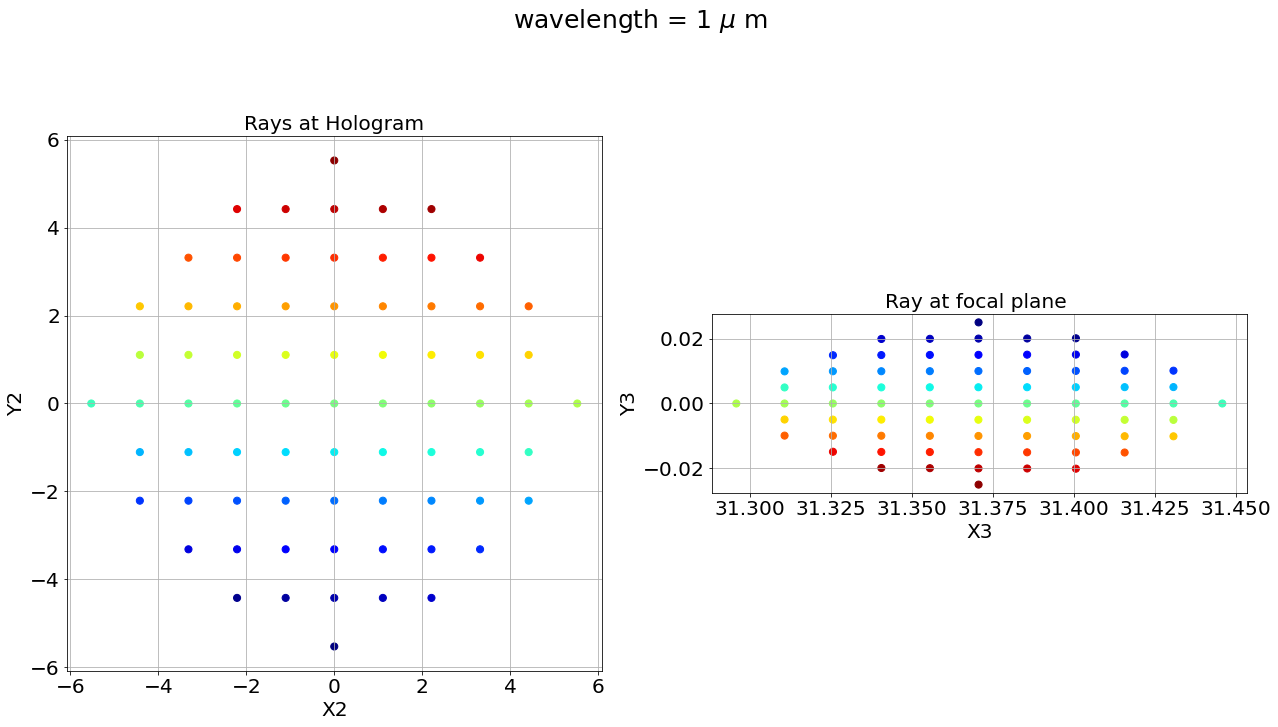

In [54]:
f, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,9))
df_IR.plot.scatter(x="X2", y="Y2",c=all_colors,marker="o",ax=ax1,s=50)
ax1.set_aspect("equal")
ax1.grid()
if FLAG_R150 :
    ax1.set_title("Rays at Ronchi 150")
elif FLAG_HOETILT:
    ax1.set_title("Rays at Hologram (tilt)") 
else:
    ax1.set_title("Rays at Hologram") 

df_IR.plot.scatter(x="X3", y="Y3",c=all_colors,marker="o",ax=ax2,s=50)
ax2.set_aspect("equal")
ax2.grid()
ax2.set_title("Ray at focal plane ")

plt.suptitle("wavelength = 1 $\mu$ m",Y=1.1,fontsize=25)
plt.tight_layout()

## PSF

Text(0.5, 0, 'Y (mm)')

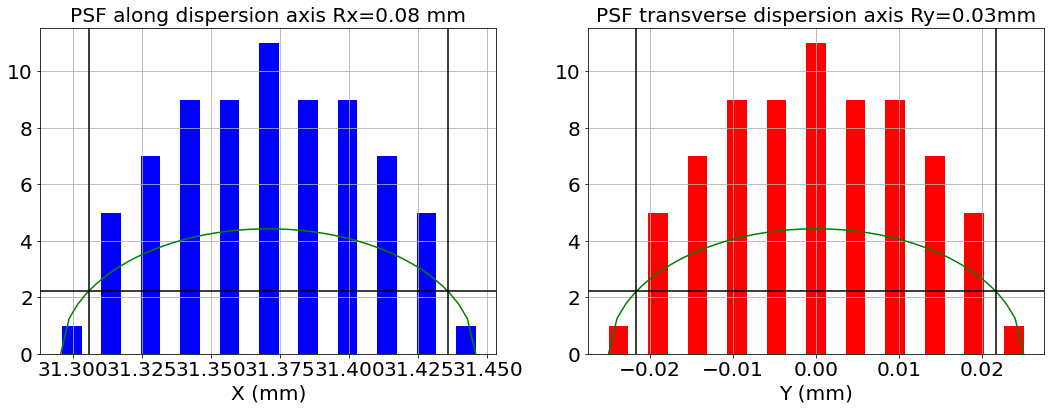

In [55]:
f, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,6))
Xpos=df_IR["X3"].values
Ypos=df_IR["Y3"].values
NBINS=21
RX=Xpos.max()-Xpos.mean()
RY=Ypos.max()-Ypos.mean()
h1=np.histogram(Xpos,bins=NBINS)
h2=np.histogram(Ypos,bins=NBINS)

counts1, bins1 = h1
counts2, bins2 = h2

NPOINTS=50
all_x=np.linspace(-RX,RX,NPOINTS)
all_y=np.linspace(-RY,RY,NPOINTS)
DX=2/NBINS*NBEAMS*(2*RX)
DY=2/NBINS*NBEAMS*(2*RY)

Yx=1/np.pi/RX*DX*np.sqrt(1-all_x**2/RX**2)
Yy=1/np.pi/RY*DY*np.sqrt(1-all_y**2/RY**2)
YxMax=1/np.pi/RX*DX
YyMax=1/np.pi/RY*DY

#ax1.hist(Xpos,bins=NBINS,facecolor="blue",density=True)
ax1.hist(bins1[:-1], bins1, weights=counts1,facecolor="blue",density=False)
ax1.plot(all_x+Xpos.mean(),Yx,color='green')
ax1.grid()
ax1.set_title("PSF along dispersion axis Rx={:2.2f} mm".format(RX))
ax1.axhline(y=YxMax/2,color="k")
ax1.axvline(x=-np.sqrt(3)*RX/2.+Xpos.mean(),color="k")
ax1.axvline(x=np.sqrt(3)*RX/2.+Xpos.mean(),color="k")
ax1.set_xlabel("X (mm)")

#ax2.hist(Ypos,bins=NBINS,facecolor="red",density=True)
ax2.hist(bins2[:-1], bins2, weights=counts2,facecolor="red",density=False)
ax2.plot(all_y+Ypos.mean(),Yy,color="green")
ax2.axhline(y=YyMax/2.,color="k")
ax2.axvline(x=-np.sqrt(3)*RY/2.+Ypos.mean(),color="k")
ax2.axvline(x=np.sqrt(3)*RY/2.+Ypos.mean(),color="k")
ax2.grid()
ax2.set_title("PSF transverse dispersion axis Ry={:2.2f}mm".format(RY))
ax2.set_xlabel("Y (mm)")

## Fit transverse dispersion

In [56]:
@custom_model
def exponential(x, a=10., b=1., c=0.):
    '''
    f(x)=a*exp(b*x + c)
    '''
    return a*np.exp(-np.abs(b*(x-c)))

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude                mean                stddev      
    ------------------ ----------------------- ------------------
    3.4761905085524543 -1.4849129075404815e-13 116.60616223938268
Model: Lorentz1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude               x_0                  fwhm      
    ----------------- ----------------------- -----------------
    3.476190580703239 -4.2903205694673925e-12 1547.280494707908
Model: Trapezoid1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude      x_0 width slope
    ------------------ --- ----- -----
    3.4761904761904763 0.0   1.0   1.0
Model: exponential
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
            a                  b                    c          
    ----------------- -------------------- --------------------
    3.477211085768553 0.005948864595322606 -0.04

Text(0.5, 1.0, 'Fit PSF in Y axis')

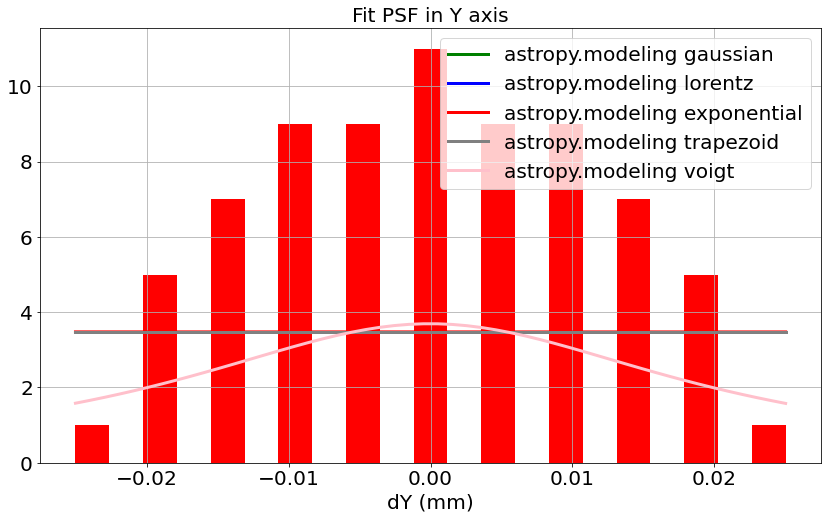

In [57]:
f, ax = plt.subplots(figsize=(14,8))
Xpos=df_IR["X3"].values
Ypos=df_IR["Y3"].values
NBINS=21
RX=Xpos.max()-Xpos.mean()
RY=Ypos.max()-Ypos.mean()
# compute the histogram
h1=np.histogram(Xpos,bins=NBINS)
h2=np.histogram(Ypos,bins=NBINS)
counts1, bins1 = h1
counts2, bins2 = h2

# compute bin width
binwidths2=(np.roll(bins2,-1)-bins2)[:-1]
binwidth2=np.mean(binwidths2)

# What to fit
theX=(bins2+binwidth2/2)[:-1]
theY=counts2

# fitter 
#fitter = fitting.LinearLSQFitter()
fitter = fitting.LevMarLSQFitter() 

# gaussian fit
model_gauss = models.Gaussian1D()
fitter_gauss = fitting.LevMarLSQFitter()
best_fit_gauss = fitter_gauss(model_gauss, theX,theY,weights=1)
print(best_fit_gauss)

# models in astropy
model_lorentz = models.Lorentz1D(amplitude=10., x_0=0.)
model_trapezoid = models.Trapezoid1D(amplitude=100., x_0=0.)
#model_exponential = models.Exponential1D(amplitude=10.,fwhm=0.05)
model_exponential = exponential(a=10., b=1., c=0.)
model_voigt = models.Voigt1D()

best_fit_lorentz=fitter(model_lorentz, theX,theY,weights=1)
best_fit_trapezoid=fitter(model_trapezoid, theX,theY,weights=1)
best_fit_exponential=fitter(model_exponential, theX,theY,weights=1)
best_fit_voigt=fitter(model_voigt, theX,theY,weights=1)

# do the fit
#best_fit = fitter(model, log_period, k_mag, weights=1.0/k_mag_err**2)
print(best_fit_lorentz)
print(best_fit_trapezoid)
print(best_fit_exponential)
print(best_fit_voigt)

ax.hist(bins2[:-1], bins2, weights=counts2,facecolor="red",density=False)

Xfit=np.linspace(-RY,RY,50)
plt.plot(Xfit, best_fit_gauss(Xfit), 'g-', linewidth=3, label='astropy.modeling gaussian')
plt.plot(Xfit, best_fit_lorentz(Xfit), 'b-', linewidth=3, label='astropy.modeling lorentz')
plt.plot(Xfit, best_fit_exponential(Xfit), 'r-', linewidth=3, label='astropy.modeling exponential')
plt.plot(Xfit, best_fit_trapezoid(Xfit), '-', color="grey",linewidth=3, label='astropy.modeling trapezoid')
plt.plot(Xfit, best_fit_voigt(Xfit), '-', color="pink",linewidth=3, label='astropy.modeling voigt')

ax.grid()
ax.legend()
ax.set_xlabel("dY (mm)")
ax.set_title("Fit PSF in Y axis")

# decoding by wavelength

In [58]:
wave=df["wave"]

In [59]:
Xfinal=df["Xfinal"].values
Yfinal=df["Yfinal"].values

In [60]:
selected_indexes1=np.where(wave==0.0004)
selected_indexes2=np.where(wave==0.0006)
selected_indexes3=np.where(wave==0.0008)
selected_indexes4=np.where(wave==0.0010)

In [61]:
selected_indexes1

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72]),)

In [62]:
def GetInfo(a):
    a_av=np.mean(a)
    a_rms=np.std(a)
    a_min=np.min(a)
    a_max=np.max(a)
    a_width=a_max-a_min
    return a_av,a_rms,a_min,a_max,a_width

In [63]:
def ComputeFWHM(values,nbins,thetitle="fwhm",flagplot=False):
    """
    ComputeFWHM(values,nbins,flagplot)
    
    input arg :
       values : list of values
       nbins. : number of bins in the histogram
       flagplot : flag to plot the distribution
    """
    
    counts, bins =np.histogram(values,bins=nbins)
    
    # compute bin width
    binwidths=(np.roll(bins,-1)-bins)[:-1]
    binwidth=np.mean(binwidths)
    
    # find max
    idx_max=np.where(counts==counts.max())[0][0]
    count_max=counts[idx_max]
    counts_halfmax=count_max/2.
    
    # bins above half max
    topmost=np.where(counts>=counts_halfmax)[0]
    idx_min_fwhm=topmost[0]
    idx_max_fwhm=topmost[-1]
    
    # lower upper part
    min_fwhm=bins[idx_min_fwhm]+binwidth/2.
    max_fwhm=bins[idx_max_fwhm]+binwidth/2.
    
    #fwhm
    fwhm=max_fwhm-min_fwhm
    
    
    if flagplot:
        f, ax = plt.subplots(figsize=(10,5))
        
        ax.hist(bins[:-1]+binwidth/2., bins+binwidth/2., weights=counts,facecolor="red",density=False)
        ax.axhline(y=counts_halfmax)
        ax.axvline(x=min_fwhm,color="k")
        ax.axvline(x=max_fwhm,color="k")
        
        ax.grid()
        ax.set_title(thetitle)
        
    return fwhm
            

In [64]:
x1=Xfinal[selected_indexes1[0]]
y1=Yfinal[selected_indexes1[0]]
x1av,x1std,x1min,x1max,x1wdt=GetInfo(x1)
y1av,y1std,y1min,y1max,y1wdt=GetInfo(y1)

In [65]:
fwhmx1=ComputeFWHM(x1-x1av,nbins=11,thetitle="FWHM x1",flagplot=False)
fwhmy1=ComputeFWHM(y1-y1av,nbins=11,thetitle="FWHM y1",flagplot=False)
print("fwhm_x1= = {:2.2f}, fwhm_y1={:2.4f}".format(fwhmx1,fwhmy1))

fwhm_x1= = 0.02, fwhm_y1=0.0069


In [66]:
rxmax1=np.max([x1.max()-x1av,x1av-x1.min()])
rymax1=np.max([y1.max()-y1av,y1av-y1.min()])
print("rmax_x1= = {:2.2f}, rmax_y1={:2.4f}".format(rxmax1,rymax1))

rmax_x1= = 0.02, rmax_y1=0.0064


In [67]:
x2=Xfinal[selected_indexes2[0]]
y2=Yfinal[selected_indexes2[0]]
x2av,x2std,x2min,x2max,x2wdt=GetInfo(x2)
y2av,y2std,y2min,y2max,y2wdt=GetInfo(y2)

In [68]:
fwhmx2=ComputeFWHM(x2-x2av,nbins=11,thetitle="FWHM x2",flagplot=False)
fwhmy2=ComputeFWHM(y2-y2av,nbins=11,thetitle="FWHM y2",flagplot=False)
print("fwhm_x2= = {:2.2f}, fwhm_y2={:2.4f}".format(fwhmx2,fwhmy2))

fwhm_x2= = 0.00, fwhm_y2=0.0016


In [69]:
rxmax2=np.max([x2.max()-x2av,x2av-x2.min()])
rymax2=np.max([y2.max()-y2av,y2av-y2.min()])
print("rmax_x2= = {:2.2f}, rmax_y2={:2.4f}".format(rxmax2,rymax2))

rmax_x2= = 0.00, rmax_y2=0.0015


In [70]:
x3=Xfinal[selected_indexes3[0]]
y3=Yfinal[selected_indexes3[0]]
x3av,x3std,x3min,x3max,x3wdt=GetInfo(x3)
y3av,y3std,y3min,y3max,y3wdt=GetInfo(y3)

In [71]:
fwhmx3=ComputeFWHM(x3-x3av,nbins=11,thetitle="FWHM x3",flagplot=False)
fwhmy3=ComputeFWHM(y3-y3av,nbins=11,thetitle="FWHM y3",flagplot=False)
print("fwhm_x3= = {:2.2f}, fwhm_y3={:2.4f}".format(fwhmx3,fwhmy3))

fwhm_x3= = 0.03, fwhm_y3=0.0098


In [72]:
rxmax3=np.max([x3.max()-x3av,x3av-x3.min()])
rymax3=np.max([y3.max()-y3av,y3av-y3.min()])
print("rmax_x3= = {:2.2f}, rmax_y3={:2.4f}".format(rxmax3,rymax3))

rmax_x3= = 0.03, rmax_y3=0.0090


In [73]:
x4=Xfinal[selected_indexes4[0]]
y4=Yfinal[selected_indexes4[0]]
x4av,x4std,x4min,x4max,x4wdt=GetInfo(x4)
y4av,y4std,y4min,y4max,y4wdt=GetInfo(y4)

In [74]:
fwhmx4=ComputeFWHM(x4-x4av,nbins=11,thetitle="FWHM x4",flagplot=False)
fwhmy4=ComputeFWHM(y4-y4av,nbins=11,thetitle="FWHM y4",flagplot=False)
print("fwhm_x4= = {:2.2f}, fwhm_y4={:2.4f}".format(fwhmx4,fwhmy4))

fwhm_x4= = 0.08, fwhm_y4=0.0273


In [75]:
rxmax4=np.max([x4.max()-x4av,x4av-x4.min()])
rymax4=np.max([y4.max()-y4av,y4av-y4.min()])
print("rmax_x4= = {:2.2f}, rmax_y4={:2.4f}".format(rxmax4,rymax4))

rmax_x4= = 0.08, rmax_y4=0.0250


In [76]:
xav=np.array([x1av,x2av,x3av,x4av])
xstd=np.array([x1std,x2std,x3std,x4std])
xmin=np.array([x1min,x2min,x3min,x4min])
xmax=np.array([x1max,x2max,x3max,x4max])
xwdt=np.array([x1wdt,x2wdt,x3wdt,x4wdt])
xfwhm=np.array([fwhmx1,fwhmx2,fwhmx3,fwhmx4])
xrmax=np.array([rxmax1,rxmax2,rxmax3,rxmax4])
yav=np.array([y1av,y2av,y3av,y4av])
ystd=np.array([y1std,y2std,y3std,y4std])
ymin=np.array([y1min,y2min,y3min,y4min])
ymax=np.array([y1max,y2max,y3max,y4max])
ywdt=np.array([y1wdt,y2wdt,y3wdt,y4wdt])
yfwhm=np.array([fwhmy1,fwhmy2,fwhmy3,fwhmy4])
yrmax=np.array([rymax1,rymax2,rymax3,rymax4])

In [77]:
#dataout = {'xav': xav,'xstd' :xstd,'xmin' :xmin,'xmax' :xmax,'xwdt':xwdt,
#           'yav': yav,'ystd' :ystd,'ymin' :ymin,'ymax' :ymax,'ywdt':ywdt}

In [78]:
dataout = {'xav': xav,'xstd' :xstd,'xmin' :xmin,'xmax' :xmax,'xwdt':xwdt,'xfwhm':xfwhm,'xrmax':xrmax,
           'yav': yav,'ystd' :ystd,'ymin' :ymin,'ymax' :ymax,'ywdt':ywdt,'yfwhm':yfwhm,'yrmax':yrmax}

In [79]:
df_out = pd.DataFrame(dataout, index = ['400nm', '600nm', '800nm', '1000nm'])

In [80]:
df_out.head()

,xav,xstd,xmin,xmax,xwdt,xfwhm,xrmax,yav,ystd,ymin,ymax,ywdt,yfwhm,yrmax
400nm,12.419323,0.009163,12.40051,12.43843,0.03792,0.020684,0.019107,-1.425800e-19,0.003074,-0.00636,0.00636,0.01272,0.006938,0.00636
600nm,18.674470,0.002096,18.67029,18.67897,0.00868,0.004735,0.004500,5.049709e-20,0.000702,-0.00146,0.00146,0.00292,0.001593,0.00146
800nm,24.984983,0.012935,24.95839,25.01191,0.05352,0.029193,0.026927,-4.752667e-20,0.004328,-0.00896,0.00896,0.01792,0.009775,0.00896
1000nm,31.370606,0.036230,31.29585,31.44577,0.14992,0.081775,0.075164,-7.604267e-19,0.012086,-0.02502,0.02502,0.05004,0.027295,0.02502


In [81]:
df_out.to_excel(outputdata_excel)

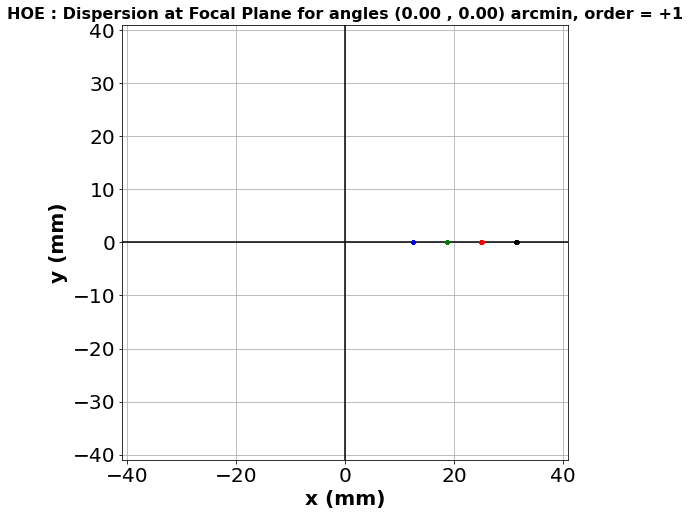

In [82]:
plt.figure(figsize=(8,8))
plt.axhline(y=0,color="k")
plt.axvline(x=0,color="k")
plt.plot(x1,y1,"b.")
plt.plot(x2,y2,"g.")
plt.plot(x3,y3,"r.")
plt.plot(x4,y4,"k.")

plt.xlim(-Det_size/2,Det_size/2.)
plt.ylim(-Det_size/2,Det_size/2)
plt.grid(True)
plt.xlabel("x (mm)",fontweight='bold')
plt.ylabel("y (mm)",fontweight='bold')

plt.title(fulltitle1,fontsize=16,fontweight='bold')
plt.savefig(figname1)

In [83]:
seeing_radius=1./pltscale/2. # in mm

In [84]:
seeing_radius

0.0523598283761181

In [85]:
def Showscale(x,y,w,label,ax):
    xmin=x-w/2
    xmax=x+w/2
    ymin=y-w/2
    ymax=y+w/2
    xscale=xmax-xmin
    yscale=ymax-ymin
    ax.axhline(y=y,color="k")
    ax.axvline(x=x,color="k")
    ax.plot([xmin+xscale*.1,xmin+xscale*.1+wdt/10.],[ymin+yscale*0.8,ymin+yscale*0.8],'k-',lw=2)
    ax.text(xmin+xscale*.1, ymin+yscale*0.85, label,fontsize=16, fontweight='bold')

In [86]:
def Showscale2(x,y,w,label,ax):
    xmin=x-w/2
    xmax=x+w/2
    ymin=y-w/2
    ymax=y+w/2
    xscale=xmax-xmin
    yscale=ymax-ymin
    ax.axhline(y=y,color="k")
    ax.axvline(x=x,color="k")
    ax.plot([xmax-xscale*.3,xmax-xscale*.3+wdt/10.],[ymin+yscale*0.1,ymin+yscale*0.1],'k-',lw=2)
    ax.text(xmax-xscale*.3, ymin+yscale*0.15, label,fontsize=20, fontweight='bold')

In [87]:
def Showscale3(x,y,w,wd,label,ax):
    """
        x,y,w : relative to the image
        wd : length of the label
    """
    xmin=x-w/2
    xmax=x+w/2
    ymin=y-w/2
    ymax=y+w/2
    xscale=xmax-xmin
    yscale=ymax-ymin
    #ax.axhline(y=y,color="k")
    #ax.axvline(x=x,color="k")
    ax.plot([xmax-xscale*.3,xmax-xscale*.3+wd],[ymin+yscale*0.1,ymin+yscale*0.1],'k-',lw=2)
    ax.text(xmax-xscale*.3, ymin+yscale*0.15, label,fontsize=20, fontweight='bold')

In [88]:
def Showstat(x,y,w,xstd,ystd,ax):
    
    xmin=x-w/2
    xmax=x+w/2
    ymin=y-w/2
    ymax=y+w/2
    xscale=xmax-xmin
    yscale=ymax-ymin
    stat_str_x="$\\sigma_x=${:2.2f} $\\mu$ m".format(xstd*1000)
    stat_str_y="$\\sigma_y=${:2.2f} $\\mu$ m".format(ystd*1000)
    print(stat_str_x)
    ax.text(xmax-xscale*.4, ymin+yscale*0.85, stat_str_x,fontsize=16, fontweight='bold')
    ax.text(xmax-xscale*.4, ymin+yscale*0.80, stat_str_y,fontsize=16, fontweight='bold')

In [89]:
def Showstat2(x,y,w,xstd,ystd,ax):
    
    xmin=x-w/2
    xmax=x+w/2
    ymin=y-w/2
    ymax=y+w/2
    xscale=xmax-xmin
    yscale=ymax-ymin
    stat_str_x="$\\sigma_x=${:2.2f} $\\mu$ m".format(xstd*1000)
    stat_str_y="$\\sigma_y=${:2.2f} $\\mu$ m".format(ystd*1000)
    print(stat_str_x)
    ax.text(xmin+xscale*.01, ymin+yscale*0.85, stat_str_x,fontsize=20, fontweight='bold')
    ax.text(xmin+xscale*.01, ymin+yscale*0.75, stat_str_y,fontsize=20, fontweight='bold')

In [90]:
def Showstat3(x,y,w,fwx,fwy,ax):
    
    xmin=x-w/2
    xmax=x+w/2
    ymin=y-w/2
    ymax=y+w/2
    xscale=xmax-xmin
    yscale=ymax-ymin
    stat_str_x="fwhm$_x=${:2.0f} $\\mu m$".format(fwx*1000)
    stat_str_y="fwhm$_y=${:2.0f} $\\mu m$".format(fwy*1000)
    ax.text(xmin+xscale*.01, ymin+yscale*0.85, stat_str_x,fontsize=20, fontweight='bold')
    ax.text(xmin+xscale*.01, ymin+yscale*0.75, stat_str_y,fontsize=20, fontweight='bold')

In [91]:
seeing_radius=1./pltscale/2. # in mm
seeing_str="seeing 1\" fwhm ({:2.0f}  $\mu m$) ".format(seeing_radius*2000)
seeing_str1="seeing 1\" "
seeing_str2="fwhm = {:2.0f} $\mu m$".format(seeing_radius*2000)

$\sigma_x=$9.16 $\mu$ m
$\sigma_x=$2.10 $\mu$ m
$\sigma_x=$12.94 $\mu$ m
$\sigma_x=$36.23 $\mu$ m


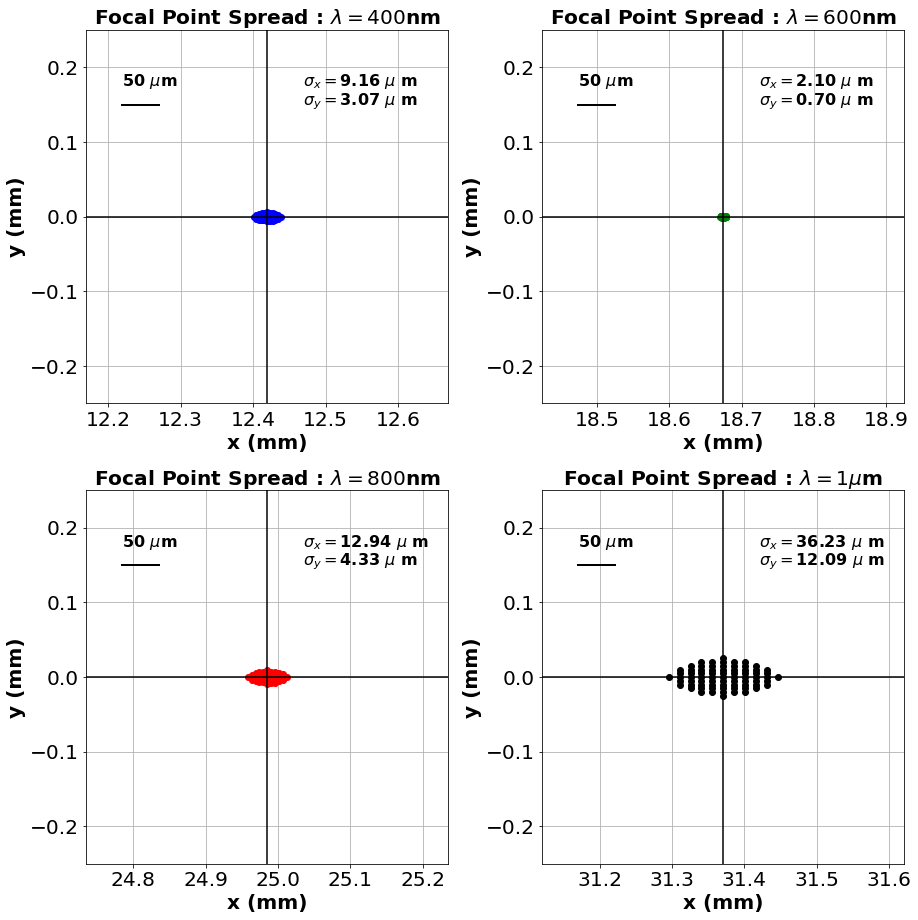

In [92]:
wdt=.50  # with 100 microns
scalelabel="50 $\mu$m"
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.plot(x1, y1,'bo')

xmin=x1av-wdt/2
xmax=x1av+wdt/2
ymin=y1av-wdt/2
ymax=y1av+wdt/2
xscale=xmax-xmin
yscale=ymax-ymin

#ax1.plot([xmin+xscale*.1,xmin+xscale*.1+wdt/10.],[ymin+yscale*0.8,ymin+yscale*0.8],'k-',lw=2)
#ax1.text(xmin+xscale*.1, ymin+yscale*0.85, scalelabel,fontsize=16, fontweight='bold')

Showscale(x1av,y1av,wdt,scalelabel,ax1)
Showstat(x1av,y1av,wdt,x1std,y1std,ax1)

ax1.set_xlim(x1av-wdt/2,x1av+wdt/2)
ax1.set_ylim(y1av-wdt/2,y1av+wdt/2)
ax1.set_title('Focal Point Spread : $\lambda=400$nm',fontweight='bold')
ax1.set_xlabel('x (mm)',fontweight='bold')
ax1.set_ylabel('y (mm)',fontweight='bold')
ax1.grid()
#----
ax2.plot(x2, y2,'go')
Showscale(x2av,y2av,wdt,scalelabel,ax2)
Showstat(x2av,y2av,wdt,x2std,y2std,ax2)
ax2.set_xlim(x2av-wdt/2,x2av+wdt/2)
ax2.set_ylim(y2av-wdt/2,y2av+wdt/2)
ax2.set_xlabel('x (mm)',fontweight='bold')
ax2.set_ylabel('y (mm)',fontweight='bold')
ax2.grid()
ax2.set_title('Focal Point Spread : $\lambda=600$nm',fontweight='bold')
#--------
ax3.plot(x3, y3,'ro')
Showscale(x3av,y3av,wdt,scalelabel,ax3)
Showstat(x3av,y3av,wdt,x3std,y3std,ax3)
ax3.set_xlim(x3av-wdt/2,x3av+wdt/2)
ax3.set_ylim(y3av-wdt/2,y3av+wdt/2)
ax3.set_xlabel('x (mm)',fontweight='bold')
ax3.set_ylabel('y (mm)',fontweight='bold')
ax3.grid()
ax3.set_title('Focal Point Spread : $\lambda=800$nm',fontweight='bold')
#-----
ax4.plot(x4, y4,'ko')
Showscale(x4av,y4av,wdt,scalelabel,ax4)
Showstat(x4av,y4av,wdt,x4std,y4std,ax4)
ax4.set_xlim(x4av-wdt/2,x4av+wdt/2)
ax4.set_ylim(y4av-wdt/2,y4av+wdt/2)
ax4.set_xlabel('x (mm)',fontweight='bold')
ax4.set_ylabel('y (mm)',fontweight='bold')
ax4.grid()
ax4.set_title('Focal Point Spread : $\lambda=1\mu$m',fontweight='bold')

#plt.suptitle(fulltitle2,fontsize=16,fontweight='bold',y=1.02)
plt.tight_layout()
plt.savefig(figname2)

$\sigma_x=$9.16 $\mu$ m
$\sigma_x=$2.10 $\mu$ m
$\sigma_x=$12.94 $\mu$ m
$\sigma_x=$36.23 $\mu$ m


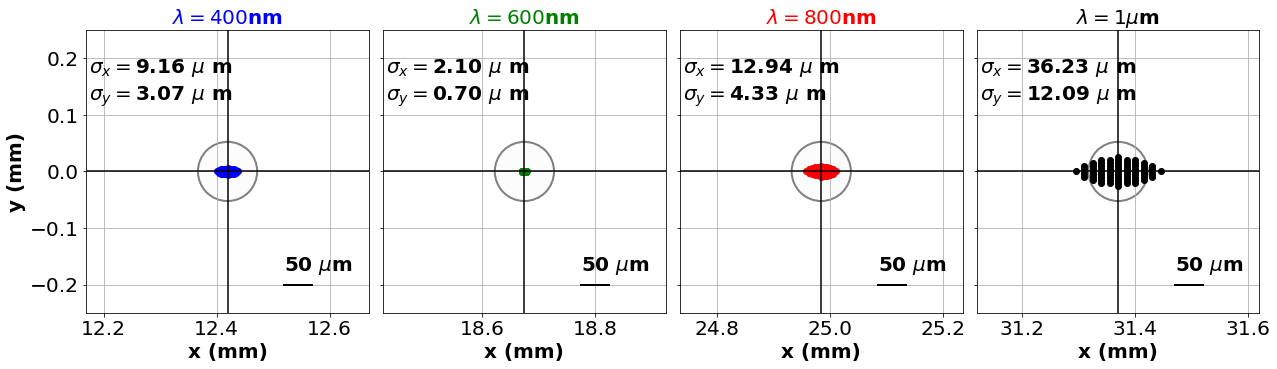

In [93]:
f, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4,figsize=(18,6),sharey=True)
#-----
ax1.plot(x1, y1,'bo')
Showscale2(x1av,y1av,wdt,scalelabel,ax1)
Showstat2(x1av,y1av,wdt,x1std,y1std,ax1)
circle1 = Circle((x1av, y1av), seeing_radius, linewidth=2,edgecolor='grey', facecolor=(0, 0, 0, .0125))
ax1.add_artist(circle1)
ax1.set_xlim(x1av-wdt/2,x1av+wdt/2)
ax1.set_ylim(y1av-wdt/2,y1av+wdt/2)
ax1.set_title('$\lambda=400$nm',fontweight='bold',color="b",fontsize=20)
ax1.set_xlabel('x (mm)',fontweight='bold',fontsize=20)
ax1.set_ylabel('y (mm)',fontweight='bold',fontsize=20)
ax1.set_aspect('equal')
ax1.grid()
#----
ax2.plot(x2, y2,'go')
Showscale2(x2av,y2av,wdt,scalelabel,ax2)
Showstat2(x2av,y2av,wdt,x2std,y2std,ax2)
circle2 = Circle((x2av, y2av), seeing_radius, linewidth=2,edgecolor='grey', facecolor=(0, 0, 0, .0125))
ax2.add_artist(circle2)
ax2.set_xlim(x2av-wdt/2,x2av+wdt/2)
ax2.set_ylim(y2av-wdt/2,y2av+wdt/2)
ax2.set_xlabel('x (mm)',fontweight='bold',fontsize=20)
#ax2.set_ylabel('y (mm)',fontweight='bold')
ax2.grid()
ax2.set_aspect('equal')
ax2.set_title('$\lambda=600$nm',fontweight='bold',color="g",fontsize=20)
#--------
ax3.plot(x3, y3,'ro')
Showscale2(x3av,y3av,wdt,scalelabel,ax3)
Showstat2(x3av,y3av,wdt,x3std,y3std,ax3)
circle3 = Circle((x3av, y3av), seeing_radius, linewidth=2,edgecolor='grey', facecolor=(0, 0, 0, .0125))
ax3.add_artist(circle3)
ax3.set_xlim(x3av-wdt/2,x3av+wdt/2)
ax3.set_ylim(y3av-wdt/2,y3av+wdt/2)
ax3.set_xlabel('x (mm)',fontweight='bold',fontsize=20)
#ax3.set_ylabel('y (mm)',fontweight='bold')
ax3.grid()
ax3.set_aspect('equal')
ax3.set_title('$\lambda=800$nm',fontweight='bold',color="r",fontsize=20)
#-----
ax4.plot(x4, y4,'ko')
Showscale2(x4av,y4av,wdt,scalelabel,ax4)
Showstat2(x4av,y4av,wdt,x4std,y4std,ax4)
circle4 = Circle((x4av, y4av), seeing_radius, linewidth=2,edgecolor='grey', facecolor=(0, 0, 0, .0125))
ax4.add_artist(circle4)
ax4.set_xlim(x4av-wdt/2,x4av+wdt/2)
ax4.set_ylim(y4av-wdt/2,y4av+wdt/2)
ax4.set_xlabel('x (mm)',fontweight='bold',fontsize=20)
ax4.set_aspect('equal')
#ax4.set_ylabel('y (mm)',fontweight='bold')
ax4.grid()
ax4.set_title('$\lambda=1\mu$m',fontweight='bold',color="k",fontsize=20)
#plt.suptitle(fulltitle2,fontsize=16,fontweight='bold',y=1.02)


plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig(figname3)

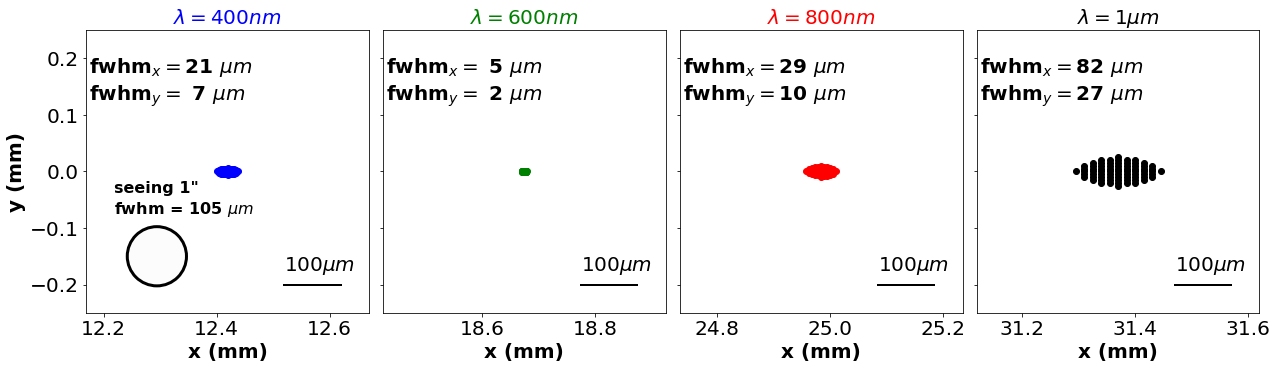

In [94]:
f, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4,figsize=(18,6),sharey=True)
#-----
ax1.plot(x1, y1,'bo')
#Showscale2(x1av,y1av,wdt,scalelabel,ax1)
Showscale3(x1av,y1av,wdt,0.1,"$100 \mu m$",ax1)
#Showstat2(x1av,y1av,wdt,x1std,y1std,ax1)
Showstat3(x1av,y1av,wdt,fwhmx1,fwhmy1,ax1)
circle1 = Circle((x1av-wdt/4, y1av-wdt/2*3/4*(1-1/5)), seeing_radius, linewidth=3,edgecolor='black', facecolor=(0, 0, 0, .0125))
ax1.text(x1av-wdt/2*(1-1/5), y1av-wdt/2*3/4*(1-4/5),seeing_str1,fontsize=16, fontweight='bold')
ax1.text(x1av-wdt/2*(1-1/5), y1av-wdt/2*3/4*(1-3/5),seeing_str2,fontsize=16, fontweight='bold')
ax1.add_artist(circle1)
ax1.set_xlim(x1av-wdt/2,x1av+wdt/2)
ax1.set_ylim(y1av-wdt/2,y1av+wdt/2)
ax1.set_title('$\lambda=400 nm$',fontweight='bold',color="b",fontsize=20)
ax1.set_xlabel('x (mm)',fontweight='bold',fontsize=20)
ax1.set_ylabel('y (mm)',fontweight='bold',fontsize=20)
ax1.set_aspect('equal')
#ax1.grid()
#----
ax2.plot(x2, y2,'go')
#Showscale2(x2av,y2av,wdt,scalelabel,ax2)
Showscale3(x2av,y2av,wdt,0.1,"$100 \mu m$",ax2)
#Showstat2(x2av,y2av,wdt,x2std,y2std,ax2)  # plot std
Showstat3(x2av,y2av,wdt,fwhmx2,fwhmy2,ax2) # plot fwhm
#circle2 = Circle((x2av-wdt/4, y2av-wdt/2*3/4), seeing_radius, linewidth=2,edgecolor='grey', facecolor=(0, 0, 0, .0125))
#ax2.text(x2av-wdt/2*(1-1/5), y2av-wdt/2*3/4*(1-1/5),seeing_str,fontsize=16, fontweight='bold')
#ax2.add_artist(circle2)
ax2.set_xlim(x2av-wdt/2,x2av+wdt/2)
ax2.set_ylim(y2av-wdt/2,y2av+wdt/2)
ax2.set_xlabel('x (mm)',fontweight='bold',fontsize=20)
#ax2.set_ylabel('y (mm)',fontweight='bold')
#ax2.grid()
ax2.set_aspect('equal')
ax2.set_title('$\lambda=600 nm$',fontweight='bold',color="g",fontsize=20)
#--------
ax3.plot(x3, y3,'ro')
#Showscale2(x3av,y3av,wdt,scalelabel,ax3)
Showscale3(x3av,y3av,wdt,0.1,"$100 \mu m$",ax3)
#Showstat2(x3av,y3av,wdt,x3std,y3std,ax3) # plot sigma
Showstat3(x3av,y3av,wdt,fwhmx3,fwhmy3,ax3) # plot fwhm
#circle3 = Circle((x3av-wdt/4, y3av-wdt/2*3/4), seeing_radius, linewidth=2,edgecolor='grey', facecolor=(0, 0, 0, .0125))
#ax3.text(x3av-wdt/2*(1-1/5), y3av-wdt/2*3/4*(1-1/5),seeing_str,fontsize=16, fontweight='bold')
#ax3.add_artist(circle3)
ax3.set_xlim(x3av-wdt/2,x3av+wdt/2)
ax3.set_ylim(y3av-wdt/2,y3av+wdt/2)
ax3.set_xlabel('x (mm)',fontweight='bold',fontsize=20)
#ax3.set_ylabel('y (mm)',fontweight='bold')
#ax3.grid()
ax3.set_aspect('equal')
ax3.set_title('$\lambda=800 nm$',fontweight='bold',color="r",fontsize=20)
#-----
ax4.plot(x4, y4,'ko')
#Showscale2(x4av,y4av,wdt,scalelabel,ax4)
Showscale3(x4av,y4av,wdt,0.1,"$100 \mu m$",ax4)
#Showstat2(x4av,y4av,wdt,x4std,y4std,ax4) # plt sigma
Showstat3(x4av,y4av,wdt,fwhmx4,fwhmy4,ax4) # plot fwhm
#circle4 = Circle((x4av-wdt/4, y4av-wdt/2*3/4), seeing_radius, linewidth=2,edgecolor='grey', facecolor=(0, 0, 0, .0125))
#ax4.text(x4av-wdt/2*(1-1/5), y4av-wdt/2*3/4*(1-1/5),seeing_str,fontsize=16, fontweight='bold')
#ax4.add_artist(circle4)
ax4.set_xlim(x4av-wdt/2,x4av+wdt/2)
ax4.set_ylim(y4av-wdt/2,y4av+wdt/2)
ax4.set_xlabel('x (mm)',fontweight='bold',fontsize=20)
ax4.set_aspect('equal')
#ax4.set_ylabel('y (mm)',fontweight='bold')
#ax4.grid()
ax4.set_title('$\lambda=1\mu m$',fontweight='bold',color="k",fontsize=20)
#plt.suptitle(fulltitle2,fontsize=16,fontweight='bold',y=1.02)


plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig(figname3)

# Interpolate

In [95]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [96]:
from scipy.interpolate import interp1d

In [97]:
X=df_out.index.values
Y=df_out['xstd'].values*1000 # in microns units

In [98]:
X=np.array([400.,600.,800.,1000.])

In [99]:
f = interp1d(X, Y, kind='cubic')

In [100]:
Xint=np.linspace(X[0],X[-1],100)
Yint=f(Xint)

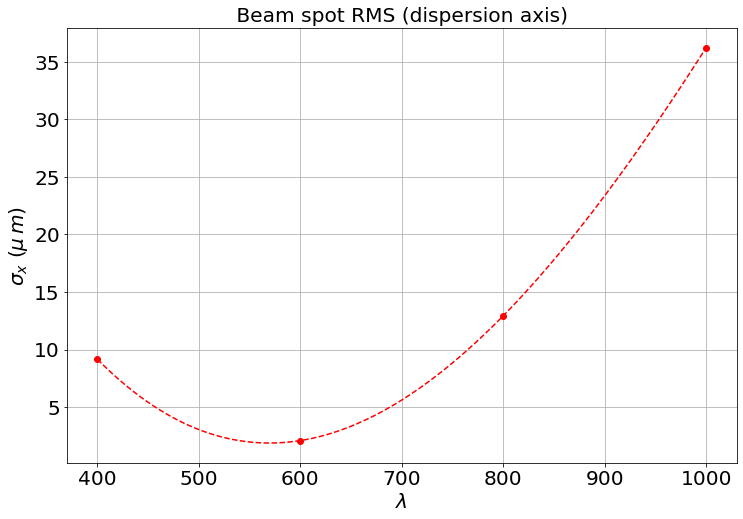

In [101]:
plt.figure(figsize=(12,8))
plt.plot(X,Y,'ro')
plt.plot(Xint,Yint,"r--")
plt.title(" Beam spot RMS (dispersion axis) ")
plt.xlabel("$\lambda$")
plt.ylabel("$\sigma_x$ ($\mu \, m$)")
plt.grid()